In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit

## 1. Run a logistic regression on the estimation list of 200 persons predicting y as a function of gender and the seven hotline variables and the intercept (constant) term. Do not eliminate coefficients which appear statistically insignificant. Hand-in: The score equation for t from the logistic regression.

In [132]:
estimation = pd.read_excel("prospectscoringhw.xlsx", sheet_name = 'Estimation_data')
holdout = pd.read_excel("prospectscoringhw.xlsx", sheet_name = 'Holdout_data')

In [26]:
y_train = estimation['y']
X_train = estimation.drop(['y'], axis = 1)
X_train = sm.add_constant(X_train)

m1 = sm.Logit(y_train, X_train)

result1 = m1.fit()

Optimization terminated successfully.
         Current function value: 0.579248
         Iterations 6


In [38]:
coefficients1 = result1.params.drop('const')

intercept1 = result1.params['const']

variable_names1 = coefficients1.index.tolist()

equation1 = f'Logit(p) = {intercept1:.4f}'

for i, coef in enumerate(coefficients1):
    sign = '+' if coef >= 0 else '-' 
    equation1 += f' {sign} {abs(coef):.4f}*{variable_names[i]}'

print("Score equation for t:")
print(equation1)

Score equation for t:
Logit(p) = -10.3659 - 0.0472*Gender + 0.0060*foodwebsites + 0.0439*travelwebsites + 0.0698*restaurantexp + 0.0341*travelexp + 0.0089*entertainmentexp - 0.0009*incm - 0.0008*ethnicdivneigh


## 2. Evaluate the score function for each person in the holdout list of 300 persons. Based on this, compute the following for each person: (1) the predicted response probability r, (2) the consequent lift, which is obtained by dividing the predicted response probability by the average response rate in the estimation list. No Hand-in.

In [110]:
y_test = holdout['y']
X_test = holdout.drop(['y'], axis = 1)

X_test['score'] = np.sum(X_test * coefficients1, axis = 1) + intercept

### (1)

In [55]:
X_test['r'] = np.exp(X_test['score']) / (1 + np.exp(X_test['score']))
X_test['r']

0      0.525970
1      0.554112
2      0.320354
3      0.723885
4      0.268740
         ...   
295    0.251233
296    0.073607
297    0.723784
298    0.272157
299    0.361369
Name: r, Length: 300, dtype: float64

### (2)

In [57]:
X_test['lift'] = X_test['r'] / np.mean(estimation['y']) 
X_test['lift']

0      1.461026
1      1.539201
2      0.889874
3      2.010792
4      0.746499
         ...   
295    0.697870
296    0.204465
297    2.010512
298    0.755993
299    1.003803
Name: lift, Length: 300, dtype: float64

## 3. Sort all the 300 persons in the holdout list in decreasing order of lift as is done in slide 30. No Hand-in. 

In [58]:
X_test = X_test.sort_values(by = 'lift', ascending=False)
X_test

,Gender,foodwebsites,travelwebsites,restaurantexp,travelexp,entertainmentexp,incm,ethnicdivneigh,score,r,lift
131,1,317,57,70,63,12,26,0,1.100660,0.750384,2.084399
243,0,321,57,70,63,0,28,0,1.063076,0.743278,2.064661
191,0,315,57,70,63,0,0,14,1.040887,0.739021,2.052836
159,0,311,57,70,63,0,0,0,1.028721,0.736668,2.046299
19,1,314,57,70,63,0,0,0,0.999388,0.730938,2.030384
...,...,...,...,...,...,...,...,...,...,...,...
211,0,406,39,0,63,0,26,0,-4.104896,0.016224,0.045067
152,0,291,39,10,52,0,0,28,-4.468435,0.011335,0.031487
96,0,159,57,15,41,0,26,0,-4.493316,0.011060,0.030722
285,1,354,30,10,52,0,0,0,-4.511036,0.010868,0.030188


## 4. Plot the curve for marginal response rate vs number of solicitations made, like in the chart that appears on slide 31. The “marginal response rate” of the person at rank n is the nth-highest predicted response probability r. The plot should have the rank on the horizontal axis and the corresponding r on the vertical axis. Hand-in: the chart. 

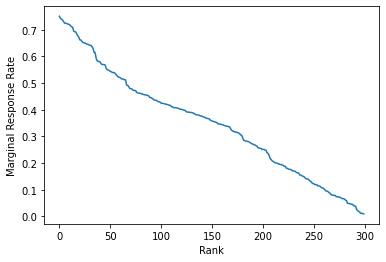

In [60]:
y = np.array(X_test['r'])

plt.xlabel('Rank')
plt.ylabel('Marginal Response Rate')
plt.plot(y)
plt.show()

## 5. Suppose average LT Customer equity is $\$30$, and the solicitation cost is $\$12$. Use the marginal cost rule to calculate how many of the best prospects in the holdout list Melrose should contact. Hand-in: your calculations and final answer. 

In [67]:
equity = 30
cost = 12
margin = cost/equity

len(X_test[X_test['r'] > margin])

121

## 6. Compute the cumulative sum (aka running sum) of the predicted response probability r when the persons are sorted as in Question 3. This cumulative sum at rank n gives the expected number of conversions or positive responses if the firm were to contact the n customers with the highest r. Plot the curve of the expected number of positive responses vs number of solicitations made, like in the chart that appears on slide 33. You will notice that the curve does not rise as fast as one would expect from the usual 80/20 rule. Explain why the curve might be of this shape here. Hand-in: the chart and your explanation. 

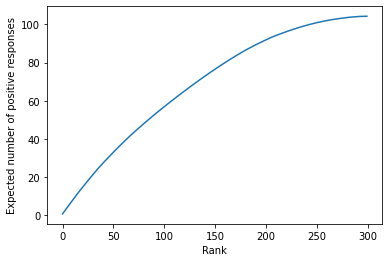

In [83]:
r_cum = np.array(X_test['r'].cumsum())

plt.xlabel('Rank')
plt.ylabel('Expected number of positive responses')
plt.plot(r_cum)
plt.show()

The curve does not rise as fast as one would expect from the usual 80/20 rule potentially because of various factors including noise, data limitations, imperfect modeling of response probabilities, and less engaged customers, while the biased coefficients arising from the potentially unrepresentative holdout list could lead to suboptimal targeting decisions.

## 7. Assume that the firm has enough raw Belgian chocolate to make only 40 boxes of the pralines offered as part of the introductory offer. Use the limited supply rule to calculate how many of the best prospects in the holdout list Melrose should send solicitations to. Hand-in: your calculations and final answer.

In [84]:
sum(r_cum <= 40)

64

## 8. To test how well the scoring model predicts actual performance, Melrose sent the solicitation offer to all 300 persons on the holdout list. The actual response is available as the y variable in the holdout list data part of the spreadsheet. Compute the cumulative sum (aka running sum) for this y variable when the persons are sorted as in Question 3. The cumulative sum of y at rank n gives the total actual number of conversions or positive responses when the firm contacted the n customers with the highest r. Plot this cumulative sum vs the number of solicitations made. Superimpose on this the curve obtained in step 6 above to get a chart akin to slide 44 . Based on this chart, comment on the discrepancies between the actual responses and the predicted response probabilities for the prospects. Comment also on the consequent impact on the decision made in step 7 above. Hand-in: the chart and your comments.

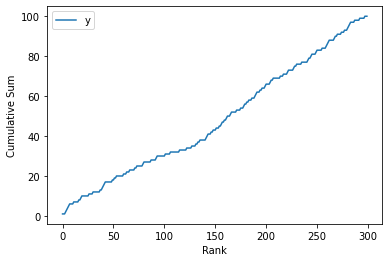

In [133]:
y_cum = y_test.cumsum()

plt.xlabel('Rank')
plt.ylabel('Cumulative Sum')
plt.plot(np.array(y_cum), label='y')
plt.legend()
plt.show()

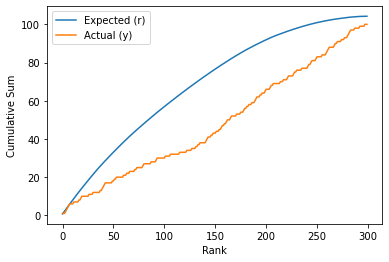

In [135]:
y_cum = y_test.cumsum()

plt.xlabel('Rank')
plt.ylabel('Cumulative Sum')
plt.plot(np.array(r_cum), label='Expected (r)')
plt.plot(np.array(y_cum), label='Actual (y)')
plt.legend()
plt.show()

The actual response probabilities are consistently lower than those predicted across all ranks, indicating potential overestimation of prospect response rates by the model, likely influenced by evolving market dynamics or shifts in customer behaviors.

This discrepancy consequently affects the decision outlined in step 7, where the top 40 prospects may not yield conversions as anticipated, prompting consideration for expanding the pool of solicitations. However, caution is advised against exceeding 64 solicitations, as this could escalate costs and potentially result in adverse customer experiences.

## 9.  [Optional for Extra Credit] Consequences of 80-20: Prove that if the Pareto 80-20 phenomenon holds then the average lift in the top 20% of the prospects will be 4. A good starting point is to consider the situation where you have  P prospects and C conversions. (The proof is only 1-2 lines. So if you find yourself thinking about something more complicated then I suggest you stop and return to it after some time. The proof is quite simple and so my expectation is that more than 75 percent of the students will be able to do it.)


$P_{20}$: Top 20% prospects

$C_{20}$: Conversions from top 20% prospects

$lift_{20}$: Average lift in top 20% prospects



$P_{20} = \frac{20}{100} * P = 0.2P$

According to the Pareto principle, 20% prospects will result in 80% conversions: $C_{20} = \frac{80}{100} * C = 0.8C$

$lift_{20} = \frac{C_{20}}{P_{20}} = \frac{0.8C}{0.2P} = \frac{0.8}{0.2} * \frac{C}{P} = 4 * \frac{C}{P}$

Therefore, if the Pareto 80-20 phenomenon holds then the average lift in the top 20% of the prospects will be 4.

## 10. Using generative AI tools

## (a)
1. python print regression result as score equation with coefficients, intercept, and vairable names

## (b)
ChatGpt

## (c)

In [ ]:
import statsmodels.api as sm

# Fit your model
model = sm.Logit(y, X)
result = model.fit()

# Get coefficients
coefficients = result.params

# Get intercept
intercept = result.params['Intercept']

# Get variable names
variable_names = X.columns.tolist()  # Assuming X is a pandas DataFrame

# Print the equation
equation = f'Logit(p) = {intercept:.2f}'

for i, coef in enumerate(coefficients):
    equation += f' + {coef:.2f}*{variable_names[i]}'

print("Logit Regression Equation:")
print(equation)